## **Χρήστος-Αλέξανδρος Δαρδαμπούνης ΑΕΜ:10335 (Τμήμα Ηλεκτρολόγων Μηχανικών & Μηχανικών Υπολογιστών)**

# Αναφορά σχετικά με την Ενδιάμεση Εργασία

Το παρόν notebook περιλαμβάνει την αναφορά σχετική με την ενδιάμεση εργασία όπου συγκρίνεται η απόδοση του αλγορίθμου πλησιέστερου γείτονα με 1 και 3 πλησιέστερους γείτονες με τον αλγόριθμο πλησιέστερου κέντρου πάνω στην CIFAR-10 ως βάση δεδομένων.


## Εισαγωγή των απαραίτητων βιβλιοθηκών και φόρτωση της βάσης δεδομένων

Αρχικά, κάνω import όλα τα απαραίτητα libraries τα οποία θα χρειαστούν για την σύγκριση των δύο αλγορίθμων οπώς επίσης φορτώνω και την βάση δεδομένων μου σύμφωνα με τις οδηγίες που αναφέρονται στο παρακάτω link : https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import pickle 
import os 
import time
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.feature import hog

Οι παραπάνω βιβλιοθήκες είναι χρήσιμες για τους εξής λόγους :
* Η **numpy** για πράξεις μεταξύ πινάκων και διανυσμάτων, για αποφυγή for loops και για κατάλληλο χειρισμό των εικόνων.
* Η **matplolib** για την οπτικοποίηση των αποτελεσμάτων μας. 
* Η **opencv(cv2)** για τον διαχειρισμό των εικόνων της CIFAR-10.
* Η **PyTorch(torch)** για την βελτιστοποίηση του δικού μου k-Nearest Neighbour καθώς και του δικού μου Nearest Centroid.
* Η **os** και η **pickle** για την φόρτωση των αρχείων της CIFAR-10.
* Επίσης από την **sklearn** κάνω import κάποιες συναρτήσεις για να συγκίνω την απόδοση των 2 αλγορίθμων με τους δικούς μου, την `accuracy_score()` για να μετρήσω την επιτύχια που έχουν οι k-Nearest Neighbour και Nearest Centroid, ενώ ακόμα κάνω import την κλάση `StandardScaler()` και την κλάση `PCA()` για να μειώσω τις διαστάσεις του προβλήματος μου και να βοηθήσω τους αλγόριθμους.
* Τέλος, εισάγω από την **skimage** την συνάρτηση `hog()` ο οποίος είναι ένας feature descriptor αλγόριθμος που μετράει τις εμφανίσεις των προσανατολισμών των gradient σε τοπικές μερίδες της εικόνας, δίνοντας έτσι χρήσιμα χαρακτηριστικά τα οποία μπορούν να χρησιμοποιηθούν αντί για ολόκληρο το set των features.

## Φόρτωση της CIFAR-10 

Στο παρακάτω κομμάτι κώδικα φορτώνω όλα τα αρχεία της βάσης και τα χωρίζω σε training και testing, όπως επίσης χωρίζω και τα labels.

In [2]:
directory = r'C:\Users\chris\OneDrive\Υπολογιστής\9ο ΕΞΑΜΗΝΟ\ΝΕΥΡΩΝΙΚΑ ΔΙΚΤΥΑ & ΒΑΘΙΑ ΜΑΘΗΣΗ\cifar-10-python\cifar-10-batches-py'
data = {}
for file in os.listdir(directory):
    with open(directory + "\\" + file, 'rb') as f:
        data[f'{file}'] =  pickle.load(f, encoding='bytes')

filename = r'C:\Users\chris\OneDrive\Υπολογιστής\9ο ΕΞΑΜΗΝΟ\ΝΕΥΡΩΝΙΚΑ ΔΙΚΤΥΑ & ΒΑΘΙΑ ΜΑΘΗΣΗ\cifar-10-python\cifar-10-batches-py\test_batch'
with open(filename, 'rb') as fo:
    test_data = pickle.load(fo, encoding='bytes')


X_train = np.vstack((data['data_batch_1'][b'data'], data['data_batch_2'][b'data'], data['data_batch_3'][b'data'], data['data_batch_4'][b'data'], data['data_batch_5'][b'data']), dtype=np.uint8)
y_train = np.hstack((data['data_batch_1'][b'labels'], data['data_batch_2'][b'labels'], data['data_batch_3'][b'labels'], data['data_batch_4'][b'labels'], data['data_batch_5'][b'labels']), dtype=np.int32)
X_test = test_data[b'data']
y_test = np.array(test_data[b'labels'])

## Image Visualization

Στην συνέχεια για να βεβαιωθώ όταν φορτώθηκαν σωστά τα αρχεία από την CIFAR-10 σχηματίζω τις εικόνες και κάνω plot ενδεικτικά μια από αυτές.

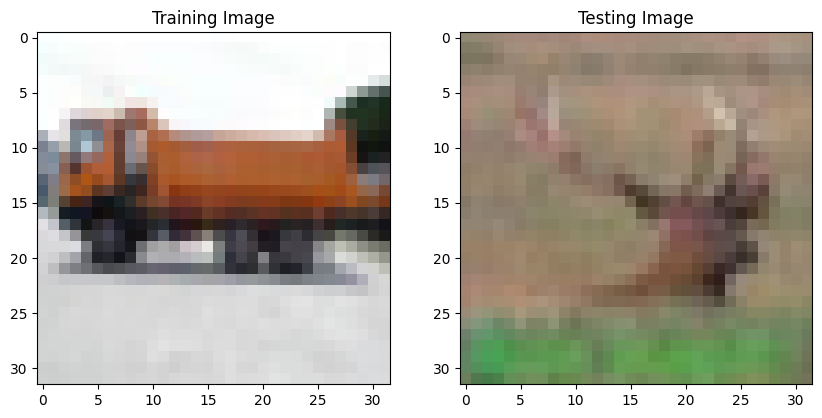

In [3]:
X = np.vstack((X_train, X_test))
img = np.zeros(shape=(32, 32, 3), dtype=np.uint8)
images = np.zeros(shape=(X.shape[0], 32, 32, 3), dtype=np.uint8)
train_images = np.zeros(shape=(X_train.shape[0], 32, 32, 3), dtype=np.uint8)
test_images = np.zeros(shape=(X_test.shape[0], 32, 32, 3), dtype=np.uint8)

for i in range(X.shape[0]):
    red_channel   = X[i, 0:1024].reshape(32, 32)
    green_channel = X[i, 1024:2048].reshape(32, 32)
    blue_channel  = X[i, 2048:3072].reshape(32, 32)

    img = np.dstack((red_channel, green_channel, blue_channel))

    images[i] = img

for i in range(X_train.shape[0]):
    red_channel   = X_train[i, 0:1024].reshape(32, 32)
    green_channel = X_train[i, 1024:2048].reshape(32, 32)
    blue_channel  = X_train[i, 2048:3072].reshape(32, 32)

    img = np.dstack((red_channel, green_channel, blue_channel))

    train_images[i] = img

for i in range(0, X_test.shape[0]):
    red_channel   = X_test[i, 0:1024].reshape(32, 32)
    green_channel = X_test[i, 1024:2048].reshape(32, 32)
    blue_channel  = X_test[i, 2048:3072].reshape(32, 32)

    img = np.dstack((red_channel, green_channel, blue_channel))
    test_images[i] = img

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(train_images[28635])
ax[0].set_title('Training Image')
ax[1].imshow(test_images[2183])
ax[1].set_title('Testing Image')
plt.show()

## Υλοποίηση του k-Nearest Neighbour και του Nearest Centroid

Στην συνέχεια παραθέτω την δικιά μου υλοποίηση για τους δύο αλγορίθμους που θέλουμε για να συγκρίνω την απόδοση τους. Στην παρούσα φάση τους υλοποιώ εκμεταλλευόμενος μόνο την `numpy`. Στην συνέχεια, παρουσιάζω και μια υλοποίηση τους σε `PyTorch` όπου έχω την δυνατότητα να τρέχω τους αλγορίθμους μου στην κάρτα γραφικών αντί για τον επεξεργαστή, γεγονός που μου δίνει μεγαλύτερες ταχύτητες επεξεργασίας.

In [4]:
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X: np.array, y: np.array):
        self.X = X # fit the training data to kNN
        self.y = y # fit the training labels to kNN

    def get_distance(self, a: np.array)->np.array:
        return np.sqrt(np.sum((self.X - a) ** 2, axis=1)) # calculate the distances

    def get_neighbours(self, point: np.array)->np.array:
        distances = self.get_distance(point)
        k_indices = np.argsort(distances)[:self.k] # get the top k indices corresponding to the smallest distances
        return k_indices

    def predict(self, X: np.array):
        predictions = []
        for example in X:
            k_indices = self.get_neighbours(example) 
            k_y_values = self.y[k_indices] # get the representative class of each k index
            prediction = np.bincount(k_y_values).argmax()  # Find the class with the highest count
            predictions.append(prediction)

        return np.array(predictions)


class MyNearestCentroid:

    def __init__(self):
        self.centroids = None
        self.classes = None

    def fit(self, X_train:np.array, y_train:np.array):

        self.classes = np.unique(y_train) # find the unique labels from the training y labels

        self.centroids = []

        for cls in self.classes:
            centroid = X_train[y_train == cls].mean(axis=0) # get the mean value of all the training data with the defined label
            self.centroids.append(centroid)

        self.centroids = np.array(self.centroids)

    def predict(self, X:np.array)->np.array:

        predictions = []

        for x in X:
            distances = np.linalg.norm((self.centroids - x), axis=1) # calculating the distance of each sample from each centroid
            classes_indexes = np.argsort(distances)[0] # getting the index corresponding to the smallest distance
            predictions.append(self.classes[classes_indexes]) # getting the corresponding label based on the previously predicted index 

        return np.array(predictions)

## Μέσες τιμές κάθε Colour Channel

Αρχικά, αντί να βάλω όλα τα features όπως μου δίνονται στους αλγορίθμους, βάζω τις μέσες τιμές της φωτεινότητας από κάθε colour channel, γεγονός που μου μειώνει σημαντικά το πλήθος των διαστάσεων του προβλημάτος από 3072 σε 3 μόνο διάστασεις. Αυτό αυξάνει σε σημαντικό βαθμό την ταχύτητα επεξεργασίας των αλγορίθμων αλλά πιθανόν να μειώνει αρκετά και την απόδοση τους και άρα και την ακρίβεια τους.

In [5]:
mean_R_X_train = np.zeros(shape=(X_train.shape[0], 1))
mean_G_X_train = np.zeros(shape=(X_train.shape[0], 1))
mean_B_X_train = np.zeros(shape=(X_train.shape[0], 1))
mean_R_X_test = np.zeros(shape=(X_test.shape[0], 1))
mean_G_X_test = np.zeros(shape=(X_test.shape[0], 1))
mean_B_X_test = np.zeros(shape=(X_test.shape[0], 1))

for i in range(X_train.shape[0]):
    mean_R_X_train[i] = np.mean(X_train[i, 0:1024])
    mean_G_X_train[i] = np.mean(X_train[i, 1024:2048])
    mean_B_X_train[i] = np.mean(X_train[i, 2048:3072])

for i in range(X_test.shape[0]):
    mean_R_X_test[i] = np.mean(X_test[i, 0:1024])
    mean_G_X_test[i] = np.mean(X_test[i, 1024:2048])
    mean_B_X_test[i] = np.mean(X_test[i, 2048:3072])

X_mean_train = np.hstack((mean_R_X_train, mean_G_X_train, mean_B_X_train))
X_mean_test = np.hstack((mean_R_X_test, mean_G_X_test, mean_B_X_test))

Ξεκινάω δοκιμάζοντας πρώτα την απόδοση των δικών μου αλγορίθμων και στην συνέχεια συγκρίνω με τους αλγόριθμους που παρέχει η scikit-learn.

In [6]:
# 1 Nearest Neighbour
start = time.time()
knn_1 = KNN(k=1)
knn_1.fit(X_mean_train, y_train)
y_preds = knn_1.predict(X_mean_test)
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_preds) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
nc_1 = MyNearestCentroid()
nc_1.fit(X_mean_train, y_train)
y_preds_nc = nc_1.predict(X_mean_test)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_preds_nc) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_1 = KNN(k=3)
knn_1.fit(X_mean_train, y_train)
y_preds = knn_1.predict(X_mean_test)
end = time.time()
print(f"Accuracy (3 Nearest Neighbours): {accuracy_score(y_test, y_preds) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 17.67%
Total execution time : 44.227572202682495
Accuracy (Nearest Centroid): 19.63%
Total execution time : 0.09180521965026855
Accuracy (3 Nearest Neighbours): 18.70%
Total execution time : 44.6509153842926


In [7]:
# 1 Nearest Neighbour
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=1)
knn_sc.fit(X_mean_train, y_train)
y_pred = knn_sc.predict(X_mean_test)
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
clf = NearestCentroid()
clf.fit(X_mean_train, y_train)
y_pred_clf = clf.predict(X_mean_test)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_pred_clf) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=3)
knn_sc.fit(X_mean_train, y_train)
y_pred = knn_sc.predict(X_mean_test)
end = time.time()
print(f"Accuracy (3 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 17.67%
Total execution time : 0.3744218349456787
Accuracy (Nearest Centroid): 19.63%
Total execution time : 0.1781444549560547
Accuracy (3 Nearest Neighbour): 18.70%
Total execution time : 0.38065123558044434


Οπώς μπορούμε να παρατηρήσουμε η απόδοση των αλγορίθμων με αυτά τα features δεν είναι τόσο καλή, γεγονός που ήταν αναμενόμενο καθότι τα features που δίνουμε δεν είναι αντιπροσωπευτικά για την κατηγοροποίηση των εικόνων στις αντίστοιχες κλάσεις. Ωστόσο, βλέπουμε πως και ο αλγόριθμος της scikit-learn αλλά και αυτός που υλοποίησα δίνουν την ίδια ακρίβεια.

## Colour Histograms

Λόγω της πολύ κακής απόδοσης που είχαν οι μέσοι όροι φωτεινότητας για το κάθε colour channel, δοκιμάζω αυτή την φορά να δώσω διαφορετικά features και συγκεκριμένα αποφασίζω να δώσω το ιστόγραμμα από κάθε colour channel το οποίο περιέχει την πολύ σημαντική πληροφορία της κατανομής της φωτεινότητας για τα τρία χρώματα για την κάθε εικόνα, γεγονός που πιθανόν να βελτιώσει την κατηγοροποίηση των εικόνων στις σωστές κλάσεις. 

In [8]:
def color_histogram(image, bins=30):

    red_hist = np.histogram(image[:, :, 0], bins=bins, range=(0, 255))[0] # getting the values of the histogram for the red colour channel
    green_hist = np.histogram(image[:, :, 1], bins=bins, range=(0, 255))[0] # getting the values of the histogram for the green colour channel
    blue_hist = np.histogram(image[:, :, 2], bins=bins, range=(0, 255))[0] # getting the values of the histogram for the blue colour channel

    hist_features = np.concatenate([red_hist, green_hist, blue_hist])
    return hist_features

H_train = np.zeros(shape=(X_train.shape[0], 90))
H_test  = np.zeros(shape=(X_test.shape[0], 90))

for i in range(train_images.shape[0]):
    H_train[i] = color_histogram(train_images[i])

for i in range(test_images.shape[0]):
    H_test[i] = color_histogram(test_images[i])

Επομένως με αυτό τον τρόπο το κάθε sample θα αποτελείται από 90 συνολικά features, 30 από τα οποία θα είναι για το κάθε επιμέρους colour channel, δηλαδή σημαντικά περισσότερη πληροφορία από ότι προηγουμένως και επίσης πιο ουσιώδης αφού περιέχει καλύτερα χαρακτηριστικά της κάθε εικόνας σε σχέση με προηγουμένως. 

Οπότε όπως και προηγουμένως δοκιμάζω πρώτα πως δουλεύει η δικιά μου υλοποίηση και στην συνέχεια δοκιμάζω την απόδοση που έχει η scikit-learn.

In [9]:
# 1 Nearest Neighbour
start = time.time()
knn_1 = KNN(k=1)
knn_1.fit(H_train, y_train)
y_preds = knn_1.predict(H_test)
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_preds) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
nc_1 = MyNearestCentroid()
nc_1.fit(H_train, y_train)
y_preds_nc = nc_1.predict(H_test)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_preds_nc) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_1 = KNN(k=3)
knn_1.fit(H_train, y_train)
y_preds = knn_1.predict(H_test)
end = time.time()
print(f"Accuracy (3 Nearest Neighbours): {accuracy_score(y_test, y_preds) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 28.34%
Total execution time : 227.28843069076538
Accuracy (Nearest Centroid): 22.02%
Total execution time : 0.10452127456665039
Accuracy (3 Nearest Neighbours): 27.83%
Total execution time : 219.85882139205933


In [10]:
# 1 Nearest Neighbour
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=1)
knn_sc.fit(H_train, y_train)
y_pred = knn_sc.predict(H_test)
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
clf = NearestCentroid()
clf.fit(H_train, y_train)
y_pred_clf = clf.predict(H_test)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_pred_clf) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=3)
knn_sc.fit(H_train, y_train)
y_pred = knn_sc.predict(H_test)
end = time.time()
print(f"Accuracy (3 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 28.34%
Total execution time : 0.5074515342712402
Accuracy (Nearest Centroid): 22.02%
Total execution time : 0.0272824764251709
Accuracy (3 Nearest Neighbour): 27.83%
Total execution time : 0.5409097671508789


Από τα παραπάνω αποτελέσματα παρατηρούμε πως έχουμε αρκετά σημαντική βελτίωση της ακρίβειας και των δύο αλγορίθμων κάτι που ήταν αναμενόμενο καθότι, πέρα από το γεγονός το ότι είναι περισσότερα features και άρα περισσότερη πληροφορία, τα features που δίνουμε είναι περισσότερο χρήσιμα από ότι προηγουμένως. Ωστόσο, εξακολουθούμε να παρατηρούμε πως η ακρίβεια και για τους δύο αλγορίθμους είναι αρκετά χαμηλή κάτι που πιθανόν να υποδηλώνει πως και οι δύο αλγόριθμοι ίσως να μην κατάλληλοι για την κατηγοροποίηση μιας τέτοιας βάσης δεδομένων όπως είναι η CIFAR-10.

## PCA 

* Στην συνέχεια δοκιμάζω να εφαρμόσω **PCA** στα δεδομένα μου που έχει ως σκοπό να βρει έναν υποχώρο διάστασης **d < p** που εξηγεί όσο το δυνατόν περισσότερο τη διασπορά των σημείων και συνεπώς συνοψίζει τις πληροφορίες των πολλών διαστάσεων σε λιγότερες  καθότι μετασχηματίζει συσχετισμένες μεταβλητές σε γραμμικά ασυσχέτιστα components.

* Όπως και προηγουμένως συγκρίνω την απόδοση των αλγορίθμων με τους δικούς για να επιβεβαιώσω ότι εκτελούν ορθά την δουλειά τους αλλά και για να δω την απόδοση τους στην βάση δεδομένων που έχω επιλέξει. 


Πριν την εφαρμογή του **PCA**, μετά από αναζήτηση που έκανα, απαιτείται ένα scaling των δεδομένων και ειδικότερα το συνιστώμενο scaling για την CIFAR-10, για κλασσικές μεθόδους μηχανικής μάθησης όπως είναι ο αλγόριθμος k Nearest Neighbour, προτείνεται ο `StandardScaler()` ο οποίος βάζει όλα τα features να έχουν μέση τιμή ίση με το 0 και διασπορά ίση με μονάδα.

In [11]:
sc = StandardScaler() # initializing the scaler class
pca = PCA(n_components=30) # initializing the PCA class

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled  = sc.transform(X_test)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

Στο παραπάνω κομμάτι κώδικα κάνω scale όλα τα features όπως ανέφερα προηγουμένως και στην συνέχεια εφαρμόζω το **PCA** κρατόντας μόνο 30 components από τα 3072 features που έχει η κάθε εικόνα της CIFAR-10, μειώνοντας με αυτό τον τρόπο σημαντικά την πολυπλοκότητα του προβλήματός μου. Ωστόσο, αυτό, όπως είδαμε και προηγουμένως, μπορεί να βοηθήσει διότι μέσα σε αυτά τα 30 components μένει η σηματνική πληροφορία.

In [12]:
# 1 Nearest Neighbour
start = time.time()
knn_1 = KNN(k=1)
knn_1.fit(X_train_pca, y_train)
y_preds = knn_1.predict(X_test_pca)
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_preds) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
nc_1 = MyNearestCentroid()
nc_1.fit(X_train_pca, y_train)
y_preds_nc = nc_1.predict(X_test_pca)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_preds_nc) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_1 = KNN(k=3)
knn_1.fit(X_train_pca, y_train)
y_preds = knn_1.predict(X_test_pca)
end = time.time()
print(f"Accuracy (3 Nearest Neighbours): {accuracy_score(y_test, y_preds) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 39.11%
Total execution time : 102.0483968257904
Accuracy (Nearest Centroid): 27.89%
Total execution time : 0.08610701560974121
Accuracy (3 Nearest Neighbours): 39.06%
Total execution time : 105.98461842536926


In [13]:
# 1 Nearest Neighbour
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=1)
knn_sc.fit(X_train_pca, y_train)
y_pred = knn_sc.predict(X_test_pca)
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
clf = NearestCentroid()
clf.fit(X_train_pca, y_train)
y_pred_clf = clf.predict(X_test_pca)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_pred_clf) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=3)
knn_sc.fit(X_train_pca, y_train)
y_pred = knn_sc.predict(X_test_pca)
end = time.time()
print(f"Accuracy (3 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 39.11%
Total execution time : 0.3683907985687256
Accuracy (Nearest Centroid): 27.89%
Total execution time : 0.01925349235534668
Accuracy (3 Nearest Neighbour): 39.06%
Total execution time : 0.3614828586578369


Από τα παραπάνω αποτελέσματα παρατηρούμε πως η χρήση του **PCA** βοήθησε σε σημαντικό βαθμό στην κατηγοροποίηση των δεδομένων και ειδικότερα τον αλγόριθμο του k Nearest Neighbour. Αυτό το αποτέλεσμα ήταν αναμενόμενο καθότι *"συμπυκνώσαμε"* την χρήσιμη πληροφορία της εικόνας που υπήρχε στα 3072 features σε μόλις 30, πράγμα που διευκόλυνε τον αλγόριθμο πλησιέστερου γείτονα να πάρει αποφάσεις. Παρόλα αυτά, τα αποτελέσματα της κατηγοροποίησης που παίρνουμε εξακολουθούν να μην είναι ικανοποιητικά και για τους δύο αλγορίθμους.

## PCA on Colour Histograms

Στην συνέχεια δοκιμάζω να εφαρμόσω **PCA** στα features που εξήγαγα από τα ιστογράμματα του κάθε colour channel, για να δοκιμάσω τα αποτελέσματα που θα προκύψουν αν και αναμένω πως θα είναι χειρότερα από το προηγούμενο πείραμα.

In [14]:
sc = StandardScaler()
pca = PCA(n_components=30)

H_train_scaled = sc.fit_transform(H_train)
H_test_scaled  = sc.transform(H_test)

H_train_pca = pca.fit_transform(H_train_scaled)
H_test_pca  = pca.transform(H_test_scaled)

Όπως και προηγουμένως εφαρμόζω και πάλι τους αλγορίθμους για να συγκρίνω την απόδοση τους.

In [15]:
# 1 Nearest Neighbour
start = time.time()
knn_1 = KNN(k=1)
knn_1.fit(H_train_pca, y_train)
y_preds = knn_1.predict(H_test_pca)
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_preds) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
nc_1 = MyNearestCentroid()
nc_1.fit(H_train_pca, y_train)
y_preds_nc = nc_1.predict(H_test_pca)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_preds_nc) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_1 = KNN(k=3)
knn_1.fit(H_train_pca, y_train)
y_preds = knn_1.predict(H_test_pca)
end = time.time()
print(f"Accuracy (3 Nearest Neighbours): {accuracy_score(y_test, y_preds) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 29.09%
Total execution time : 98.90100502967834
Accuracy (Nearest Centroid): 21.47%
Total execution time : 0.0871269702911377
Accuracy (3 Nearest Neighbours): 27.86%
Total execution time : 97.65498971939087


In [16]:
# 1 Nearest Neighbour
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=1)
knn_sc.fit(H_train_pca, y_train)
y_pred = knn_sc.predict(H_test_pca)
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
clf = NearestCentroid()
clf.fit(H_train_pca, y_train)
y_pred_clf = clf.predict(H_test_pca)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_pred_clf) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=3)
knn_sc.fit(H_train_pca, y_train)
y_pred = knn_sc.predict(H_test_pca)
end = time.time()
print(f"Accuracy (3 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 29.09%
Total execution time : 0.36922216415405273
Accuracy (Nearest Centroid): 21.47%
Total execution time : 0.015137195587158203
Accuracy (3 Nearest Neighbour): 27.86%
Total execution time : 0.33322882652282715


Όπως και ήταν αναμενόμενο τα αποτελέσματα που παίρνουμε είναι χειρότερα από προηγουμένως οπότε η τεχνική **PCA** δεν βοήθησε στην ταξινόμηση των εικόνων.

## Συνδυασμός PCA όλων των features & PCA των Colour Channels

Ας δοκιμάσουμε τώρα να δούμε τι αποτελέσματα θα δώσουν οι δύο αλγόριθμοι στην περίπτωση που συνδυάσω τα δύο προηγούμενα πειράματα μαζί. Μια αρχική εκτίμηση είναι ότι θα μας δώσουν αρκετά καλύτερα αποτελέσματα καθότι και οι δύο ξεχωριστά είχαν αρκετά καλές επιδόσεις. Συνεπώς συνδυάζοντας τα χαρακτηριστικά τους αναμένουμε καλύτερη ταξινόμηση των εικόνων σε σχέση με προηγουμένως. 

In [17]:
X_H_train_combined = np.hstack((X_train_pca, H_train_pca))
X_H_test_combined  = np.hstack((X_test_pca, H_test_pca))

In [18]:
# 1 Nearest Neighbour
start = time.time()
knn_1 = KNN(k=1)
knn_1.fit(X_H_train_combined, y_train)
y_preds = knn_1.predict(X_H_test_combined)
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_preds) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
nc_1 = MyNearestCentroid()
nc_1.fit(X_H_train_combined, y_train)
y_preds_nc = nc_1.predict(X_H_test_combined)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_preds_nc) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_1 = KNN(k=3)
knn_1.fit(X_H_train_combined, y_train)
y_preds = knn_1.predict(X_H_test_combined)
end = time.time()
print(f"Accuracy (3 Nearest Neighbours): {accuracy_score(y_test, y_preds) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 40.47%
Total execution time : 160.96559238433838
Accuracy (Nearest Centroid): 28.07%
Total execution time : 0.09685850143432617
Accuracy (3 Nearest Neighbours): 40.16%
Total execution time : 160.2369441986084


In [19]:
# 1 Nearest Neighbour
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=1)
knn_sc.fit(X_H_train_combined, y_train)
y_pred = knn_sc.predict(X_H_test_combined)
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
clf = NearestCentroid()
clf.fit(X_H_train_combined, y_train)
y_pred_clf = clf.predict(X_H_test_combined)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_pred_clf) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=3)
knn_sc.fit(X_H_train_combined, y_train)
y_pred = knn_sc.predict(X_H_test_combined)
end = time.time()
print(f"Accuracy (3 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 40.47%
Total execution time : 0.40112805366516113
Accuracy (Nearest Centroid): 28.07%
Total execution time : 0.022395610809326172
Accuracy (3 Nearest Neighbour): 40.16%
Total execution time : 0.44815611839294434


Τελικά, συμπεραίνουμε πως όντως παίρνουμε καλύτερα αποτελέσματα με τον συνδυασμό αυτών των features. Ωστόσο παρατηρούμε πως καλύτερη απόδοση είχε ο k Nearest Neighbour, σε αντίθεση με τον Nearest Centroid στον οποίο η αύξηση της ακρίβειας ήταν ελάχιστη σε σχέση με προηγουμένως.

## Ιστογράμματα HSV (Hue-Saturation-Value)

Στην συνέχεια χρησιμοποιώ τα ιστογράμματα **Hue-Saturation-Value** τα οποία είναι στην ουσία μια διαφορετική αναπαράσταση των χρωμάτων της κάθε εικόνας. Συγκεκριμένα, είναι θεωρητικά καλύτερα για εξαγωγή χρήσιμων χαρακτηριστικών από μια βάση δεδομένων όπως είναι η CIFAR-10 γιατί διακρίνουν καλύτερα την φωτεινότητα και την καθαρότητα των χρωμάτων σε σχέση με τα προηγούμενα ιστογράμματα όπου τα χρώματα και η φωτεινότητα ήταν πιο μπλεγμένα.

Αρχικά μετασχηματίζω τις εικόνες από RGB σε HSV και στην συνέχεια καλώ την συνάρτηση που είχα υλοποιήσει προηγουμένως για την δημιουργία των ιστογραμμάτων.

In [20]:
train_images_hsv = np.zeros(shape=train_images.shape, dtype=np.uint8)
test_images_hsv  = np.zeros(shape=test_images.shape, dtype=np.uint8)

for i in range(train_images.shape[0]):
    train_images_hsv[i] = cv2.cvtColor(train_images[i], cv2.COLOR_RGB2HSV)

for i in range(test_images.shape[0]):
    test_images_hsv[i]  = cv2.cvtColor(test_images[i], cv2.COLOR_RGB2HSV)


H_train_hsv = np.zeros(shape=(X_train.shape[0], 90))
H_test_hsv  = np.zeros(shape=(X_test.shape[0], 90))

for i in range(0, train_images.shape[0]):
    H_train_hsv[i] = color_histogram(train_images_hsv[i])

for i in range(0, test_images.shape[0]):
    H_test_hsv[i] = color_histogram(test_images_hsv[i])

Όπως και προηγουμένως εφαρμόζω και πάλι τους αλγορίθμους για να συγκρίνω την απόδοση τους.

In [21]:
# 1 Nearest Neighbour
start = time.time()
knn_1 = KNN(k=1)
knn_1.fit(H_train_hsv, y_train)
y_preds = knn_1.predict(H_test_hsv)
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_preds) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
nc_1 = MyNearestCentroid()
nc_1.fit(H_train_hsv, y_train)
y_preds_nc = nc_1.predict(H_test_hsv)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_preds_nc) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_1 = KNN(k=3)
knn_1.fit(H_train_hsv, y_train)
y_preds = knn_1.predict(H_test_hsv)
end = time.time()
print(f"Accuracy (3 Nearest Neighbours): {accuracy_score(y_test, y_preds) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 30.16%
Total execution time : 221.15089440345764
Accuracy (Nearest Centroid): 24.64%
Total execution time : 0.10001921653747559
Accuracy (3 Nearest Neighbours): 29.41%
Total execution time : 222.8660500049591


In [22]:
# 1 Nearest Neighbour
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=1)
knn_sc.fit(H_train_hsv, y_train)
y_pred = knn_sc.predict(H_test_hsv)
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
clf = NearestCentroid()
clf.fit(H_train_hsv, y_train)
y_pred_clf = clf.predict(H_test_hsv)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_pred_clf) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=3)
knn_sc.fit(H_train_hsv, y_train)
y_pred = knn_sc.predict(H_test_hsv)
end = time.time()
print(f"Accuracy (3 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 30.16%
Total execution time : 0.4863564968109131
Accuracy (Nearest Centroid): 24.64%
Total execution time : 0.03341865539550781
Accuracy (3 Nearest Neighbour): 29.40%
Total execution time : 0.5179953575134277


Από τα αποτελέσματα που προκύπτουν συμπεραίνουμε πως όντως λαμβάνουμε καλύτερα αποτελέσματα ταξινόμησης των εικόνων και με τους 2 αλγορίθμους σε σχέση με τα απλά ιστογράμματα για το κάθε colour channel. 

## k-Nearest Neighbour & Nearest Centroid on PyTorch

Επειδή η εκτέλεση των αλγορίθμων με την δικιά μου υλοποίηση απαιτεί αρκετό χρόνο, παραθέτω παρακάτω την υλοποίηση τους με την βοήθεια της `PyTorch` η οποία μου επιτρέπει να μεταφέρω την εκτέλεση τους από τον επεξεργαστή στην κάρτα γραφικών. 

Για τον αλγόριθμο k-Nearest Neighbour έκανα δύο υλοποιήσεις:
1. Η πρώτη είναι ουσιαστικά "μετάφραση" του κώδικα που έχω γράψει πιο πάνω, χρησιμοποιώντας συναρτήσεις της `PyTorch`. Ωστόσο, σε αυτή παρατήρησα πως όταν έδινα όλα τα 3072 features, δεν έπαιρνα την ίδια ακρίβεια με αυτή που έβγαζε η υλοποίηση της `scikit-learn`. Αυτό πιθανόν οφείλεται στο πως οι συναρτήσεις που χρησιμοποιώ παίρνουν αποφάσεις καθώς επίσης και στο γεγονός της ακρίβειας λόγω των floating points.
 
2. Η δεύτερη υλοποίηση την οποία πρότεινε το ChatGPT εκμεταλλεύεται περισσότερο τις συναρτήσεις που προσφέρει η `PyTorch` με αποτέλεσμα να είναι σημαντικά πιο γρήγορη αλλά και πιο ακριβής από την προηγούμενη.

In [31]:
class KNN_gpu:
    def __init__(self, device, k:int=3):
        self.k = k
        self.device = torch.device(device)

    def fit(self, X:torch.Tensor, y:torch.Tensor):
        self.X = X.to(self.device)
        self.y = y.to(self.device)

    def get_distance(self, a:torch.Tensor) -> torch.Tensor:
        return torch.sqrt(torch.sum( (self.X - a) ** 2, dim=1))

    def get_neighbours(self, example:torch.Tensor):
        distances = self.get_distance(example)
        k_indices = torch.argsort(distances)[:self.k]
        return k_indices

    def predict(self, X:torch.Tensor) -> torch.Tensor:
        X = X.to(self.device)
        predictions = []

        for example in X:
            k_indices  = self.get_neighbours(example)
            k_y_values = self.y[k_indices]
            prediction = torch.bincount(k_y_values).argmax()
            predictions.append(prediction.item())

        return torch.tensor(predictions, device=self.device)


class KNN_cuda:
    def __init__(self, device, k:int=3):
        self.k = k
        self.device = device

    def fit(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X.to(self.device)
        self.y = y.to(self.device)

    def predict(self, X: torch.Tensor):
        X = X.to(self.device)
        distances = torch.cdist(X, self.X)  # Compute pairwise distances between X and self.X
        k_indices = distances.topk(self.k, dim=1, largest=False).indices  # Get k smallest distances
        k_y_values = self.y[k_indices]  # Retrieve labels for the k nearest neighbors
        return torch.mode(k_y_values, dim=1).values.to('cpu')  # Return the most common class for each row


class MyNearestCentroid_cuda():

    def __init__(self, device:str='cuda'):
        self.centroids = None
        self.classes = None
        self.device = device


    def fit(self, X_train:torch.Tensor, y_train:torch.Tensor):
        
        X_train = X_train.to(self.device)
        y_train = y_train.to(self.device)

        self.classes = torch.unique(y_train)

        self.centroids = []

        for cls in self.classes:
            centroid = X_train[y_train == cls].mean(dim=0)
            self.centroids.append(centroid)

        self.centroids = torch.stack(self.centroids).to(self.device)

    def predict(self, X_test:torch.Tensor)->torch.Tensor:

        X_test = X_test.to(self.device)
        distances = torch.cdist(X_test, self.centroids)
        classes_indeces = distances.argmin(dim=1)
        predictions = self.classes[classes_indeces]

        return predictions

In [32]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7


## Histogram of Oriented Gradients

Στην συνέχεια δοκιμάζω να χρησιμοποιήσω τον αλγόριθμο **HOG**(Histogram of Oriented Gradients) ο οποίος είναι ένας πολύ συνηθισμένος feature descriptor αλγόριθμος που μετράει τις εμφανίσεις των προσανατολισμών των gradient σε τοπικές μερίδες της εικόνας, δίνοντας έτσι χρήσιμα χαρακτηριστικά τα οποία μπορούν να χρησιμοποιηθούν αντί για ολόκληρο το set των features.

Επομένως, με αυτό τον τρόπο αναμένω πως η ακρίβεια των αποτελεσμάτων μου θα αυξηθεί σε αρκετά μεγάλο βαθμό σε σχέση με προηγουμένως.

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [26]:
def compute_hog_features(image):
    hog_features, hog_image = hog(image, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), visualize=True, channel_axis=-1, transform_sqrt=True)
    return hog_features

X_train_HOG = np.zeros(shape=(train_images.shape[0], 324))
X_test_HOG  = np.zeros(shape=(test_images.shape[0], 324))

for i in range(train_images.shape[0]):
    X_train_HOG[i, :] = compute_hog_features(train_images[i])

for i in range(test_images.shape[0]):
    X_test_HOG[i, :] = compute_hog_features(test_images[i])

X_train_HOG.shape, X_test_HOG.shape

((50000, 324), (10000, 324))

In [27]:
# 1 Nearest Neighbour
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=1)
knn_sc.fit(X_train_HOG, y_train)
y_pred = knn_sc.predict(X_test_HOG)
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
clf = NearestCentroid()
clf.fit(X_train_HOG, y_train)
y_pred_clf = clf.predict(X_test_HOG)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_pred_clf) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=3)
knn_sc.fit(X_train_HOG, y_train)
y_pred = knn_sc.predict(X_test_HOG)
end = time.time()
print(f"Accuracy (3 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 49.02%
Total execution time : 1.3841140270233154
Accuracy (Nearest Centroid): 42.56%
Total execution time : 0.08960533142089844
Accuracy (3 Nearest Neighbour): 49.86%
Total execution time : 1.36338210105896


In [39]:
X_train_HOG_tensor = torch.from_numpy(X_train_HOG)
X_test_HOG_tensor  = torch.from_numpy(X_test_HOG)
y_train_tensor = torch.from_numpy(y_train)

# 1 Nearest Neighbour
start = time.time()
knn_1 = KNN_cuda(device, k=1)
knn_1.fit(X_train_HOG_tensor, y_train_tensor)
y_predictions = knn_1.predict(X_test_HOG_tensor).cpu().numpy()
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_predictions) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
nc_1 = MyNearestCentroid()
nc_1.fit(X_train_HOG, y_train)
y_preds_nc = nc_1.predict(X_test_HOG)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_preds_nc) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_2 = KNN_cuda(device, k=3)
knn_2.fit(X_train_HOG_tensor, y_train_tensor)
y_predictions = knn_2.predict(X_test_HOG_tensor).cpu().numpy()
end = time.time()
print(f"Accuracy (3 Nearest Neighbours): {accuracy_score(y_test, y_predictions) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 49.02%
Total execution time : 3.768641710281372
Accuracy (Nearest Centroid): 42.56%
Total execution time : 0.16248345375061035
Accuracy (3 Nearest Neighbours): 49.86%
Total execution time : 3.424720525741577


In [41]:
# 1 Nearest Neighbour
start = time.time()
knn_1 = KNN_gpu(device, k=1)
knn_1.fit(X_train_HOG_tensor, y_train_tensor)
y_predictions = knn_1.predict(X_test_HOG_tensor).cpu().numpy()
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_predictions) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_2 = KNN_gpu(device, k=3)
knn_2.fit(X_train_HOG_tensor, y_train_tensor)
y_predictions = knn_2.predict(X_test_HOG_tensor).cpu().numpy()
end = time.time()
print(f"Accuracy (3 Nearest Neighbours): {accuracy_score(y_test, y_predictions) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 49.02%
Total execution time : 22.50934147834778
Accuracy (3 Nearest Neighbours): 49.86%
Total execution time : 21.97100520133972


Από τα παραπάνω αποτελέσματα παρατηρούμε πως όλες οι διαφορετικές υλοποιήσεις των αλγορίθμων δίνουν τα ίδια αποτελέσματα για την ακρίβεια της ταξινόμησης στις διάφορες κλάσεις. Μια ακόμα παρατήρηση που μπορούμε να κάνουμε είναι για την ταχύτητα εκτέλεσης τους η οποία τώρα έχει μειωθεί σημαντικά καθότι ο κώδικας εκτελείται πλέον στην **GPU**. Τέλος, παρατηρούμε πως η ακρίβεια και των δύο αλγορίθμων αυξήθηκε σε σημαντικό βαθμό, φτάνοντας σχεδόν στο 50%.

## PCA στα HOG features & HOG features

Μια ακόμα δοκιμή που κάνω είναι να εφαρμόσω **PCA** στα features που πήρα από την προηγούμενη μέθοδο και να συνδυάσω αυτά τα features με τα features του **HOG**. Παρακάτω φαίνονται τα αποτελέσματα της εκτέλεσης αυτής της ιδέας. 

In [59]:
pca = PCA(n_components=100) 
sc = StandardScaler()

X_train_HOG_scaled = sc.fit_transform(X_train_HOG)
X_test_HOG_scaled = sc.transform(X_test_HOG)
X_train_HOG_pca = pca.fit_transform(X_train_HOG_scaled)
X_test_HOG_pca = pca.transform(X_test_HOG_scaled)

combined_train = np.hstack((X_train_HOG_scaled, X_train_HOG_pca))
combined_test = np.hstack((X_test_HOG_scaled, X_test_HOG_pca))

In [60]:
# 1 Nearest Neighbour
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=1)
knn_sc.fit(combined_train, y_train)
y_pred = knn_sc.predict(combined_test)
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
clf = NearestCentroid()
clf.fit(combined_train, y_train)
y_pred_clf = clf.predict(combined_test)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_pred_clf) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=3)
knn_sc.fit(combined_train, y_train)
y_pred = knn_sc.predict(combined_test)
end = time.time()
print(f"Accuracy (3 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 49.74%
Total execution time : 1.643829584121704
Accuracy (Nearest Centroid): 42.98%
Total execution time : 0.10541391372680664
Accuracy (3 Nearest Neighbour): 50.83%
Total execution time : 1.5461359024047852


In [61]:
combined_train_tensor = torch.from_numpy(combined_train)
combined_test_tensor  = torch.from_numpy(combined_test)
y_train_tensor = torch.from_numpy(y_train)

# 1 Nearest Neighbour
start = time.time()
knn_1 = KNN_cuda(device, k=1)
knn_1.fit(combined_train_tensor, y_train_tensor)
y_predictions = knn_1.predict(combined_test_tensor).cpu().numpy()
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_predictions) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
nc_1 = MyNearestCentroid()
nc_1.fit(combined_train, y_train)
y_preds_nc = nc_1.predict(combined_test)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_preds_nc) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_2 = KNN_cuda(device, k=3)
knn_2.fit(combined_train_tensor, y_train_tensor)
y_predictions = knn_2.predict(combined_test_tensor).cpu().numpy()
end = time.time()
print(f"Accuracy (3 Nearest Neighbours): {accuracy_score(y_test, y_predictions) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 49.74%
Total execution time : 4.723083257675171
Accuracy (Nearest Centroid): 42.98%
Total execution time : 0.17769217491149902
Accuracy (3 Nearest Neighbours): 50.83%
Total execution time : 4.606115102767944


Παρατηρώ ότι τα αποτελέσματα δεν αυξήθηκαν σε μεγάλο βαθμό αλλά παρόλα αυτά υπήρχε μια βελτίωση. Αυτό ήταν το υψηλότερο που κατόρθωσα να πάρω χρησιμοποιώντας διάφορες τεχνικές για την μείωση της διάστασης του προβλήματος και άρα και την πολυπλοκότητά του.

## Εισαγωγή όλων των features

Τέλος, δοκιμάζω να βάλω όλα τα features του κάθε δείγματος που δίνει η CIFAR-10 για να δω την ακρίβεια των αλγορίθμων πλησιέστερου γείτονα και του αλγόριθμου πλησιέστερου κέντρου.

In [66]:
X_train_tensor = torch.from_numpy(X_train).type(torch.float32)
X_test_tensor  = torch.from_numpy(X_test).type(torch.float32)
y_train_tensor = torch.from_numpy(y_train).type(torch.long)

# 1 Nearest Neighbour
start = time.time()
knn_1 = KNN_cuda(device, k=1)
knn_1.fit(X_train_tensor, y_train_tensor)
y_predictions = knn_1.predict(X_test_tensor).cpu().numpy()
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_predictions) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
nc_1 = MyNearestCentroid()
nc_1.fit(X_train, y_train)
y_preds_nc = nc_1.predict(X_test)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_preds_nc) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_2 = KNN_cuda(device, k=3)
knn_2.fit(X_train_tensor, y_train_tensor)
y_predictions = knn_2.predict(X_test_tensor).cpu().numpy()
end = time.time()
print(f"Accuracy (3 Nearest Neighbours): {accuracy_score(y_test, y_predictions) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 35.40%
Total execution time : 0.651972770690918
Accuracy (Nearest Centroid): 27.74%
Total execution time : 0.5248005390167236
Accuracy (3 Nearest Neighbours): 33.02%
Total execution time : 0.7371947765350342


In [67]:
# 1 Nearest Neighbour
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=1)
knn_sc.fit(X_train, y_train)
y_pred = knn_sc.predict(X_test)
end = time.time()
print(f"Accuracy (1 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

# Nearest Centroid
start = time.time()
clf = NearestCentroid()
clf.fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)
end = time.time()
print(f"Accuracy (Nearest Centroid): {accuracy_score(y_test, y_pred_clf) *100:.2f}%")
print(f'Total execution time : {end-start}')

# 3 Nearest Neighbours
start = time.time()
knn_sc = KNeighborsClassifier(n_neighbors=3)
knn_sc.fit(X_train, y_train)
y_pred = knn_sc.predict(X_test)
end = time.time()
print(f"Accuracy (3 Nearest Neighbour): {accuracy_score(y_test, y_pred) *100:.2f}%")
print(f'Total execution time : {end-start}')

Accuracy (1 Nearest Neighbour): 35.39%
Total execution time : 19.965590953826904
Accuracy (Nearest Centroid): 27.74%
Total execution time : 0.2523472309112549
Accuracy (3 Nearest Neighbour): 33.03%
Total execution time : 19.027969360351562


Από τα παραπάνω παρατηρούμε πως και οι δυο αλγόριθμοι, δηλαδή και ο k-Nearest Neighbour αλλά και ο Nearest Centroid δεν έχουν πολύ καλή απόδοση όταν βάζουμε όλα τα features χωρίς κάποια επεξεργασία τους.

Τέλος, από όλη αυτή την ανάλυση που προηγήθηκε, μπορούμε να συμπεράνουμε πως γενικότερα οι αλγόριθμοι μας  δεν αποδίδουν τόσο καλά όσο θα θέλαμε για να μπορέσουμε να ταξινομήσουμε εικόνες που προέρχονται από μια βάση δεδομένων όπως είναι η CIFAR-10. Συνεπώς, για την καλύτερη κατηγοροποίηση τους, απαιτείται ένα νευρωνικό δίκτυο το οποίο θα έχει σαφώς καλύτερη απόδοση και θα μπορέσει να κατηγοροποιήσει πιο ορθά τις εικόνες στις κατάλληλες κλάσεις.